In [1]:
import numpy as np
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import itertools

simpy.__version__

'4.0.1'

In [2]:
from sim_utility.distributions import (Bernoulli, Discrete, Poisson)

In [ ]:
seeds = [199769, 778141, 120488, 523288, 447677, 586533, 309253, 332099,
         134200, 218660, 137802, 431191, 709036, 113578, 901009, 662765,
         877876, 952621, 514789, 118072]

In [64]:
ANNUAL_DEMAND = 16328
LOW_PRIORITY_MIN_WAIT = 3
HIGH_PRIORITY_MIN_WAIT = 1

PROP_HIGH_PRORITY= 0.15
PROP_CARVE_OUT = 0.10

#target in working days
TARGET_HIGH = 5
TARGET_LOW = 20

In [65]:
class Clinic():
    '''
    A clinic has a probability of refering patients
    to another service after triage.
    '''
    def __init__(self, prob_referral_out, prob_dna):
        
        #prob patient is referred to another service
        self.prob_referral_out = prob_referral_out
        
        #probability that patients do not attend
        self.prob_dna = prob_dna
        
        self.ref_out_dist = Bernoulli(prob_referral_out)
        self.dna_dist = Bernoulli(prob_dna)

In [66]:
class ScenarioArgs():
    '''
    Arguments represent a configuration of the simulation model.
    '''
    def __init__(self, run_length): 
        self.run_length = run_length
        self.clinic_demand = pd.read_csv('data/referrals.csv')
        self.weekly_slots = pd.read_csv('data/shifts.csv')
        
        #These represent the 'diaries' of bookings
        
        # 1. carve out
        self.carve_out_slots = self.create_carve_out(run_length, self.weekly_slots)
        
        # 2. available slots and one for the bookings.
        self.available_slots = self.create_slots(self.run_length, 
                                                 self.weekly_slots)
        
        # 3. the bookings which can be used to calculate utilisation and queues over time.
        self.bookings = self.create_bookings(self.run_length,
                                             len(self.weekly_slots.columns))
        
        #sampling distributions
        self.arrival_dist = Poisson(ANNUAL_DEMAND / 52 / 5)
        self.priority_dist = Bernoulli(PROP_HIGH_PRORITY)
        
        #create a distribution for sampling a patients local clinic.
        elements = [i for i in range(len(self.clinic_demand))]
        probs = self.clinic_demand['prop'].to_numpy()
        self.clinic_dist = Discrete(elements, probs)
        
        #create a list of clinic objects
        self.clinics = []
        for i in range(len(self.clinic_demand)):
            clinic = Clinic(self.clinic_demand['referred_out'].iloc[i],
                            self.clinic_demand['dna'].iloc[i])
            self.clinics.append(clinic)
                
    def create_carve_out(self, run_length, capacity_template):

        #proportion of total capacity carved out for high priority patients
        priority_template = (capacity_template * PROP_CARVE_OUT).round().astype(np.uint8)    
            
        priority_slots = priority_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            priority_slots = pd.concat([priority_slots, priority_template.copy()], 
                                        ignore_index=True)

        priority_slots.index.rename('day', inplace=True)
        return priority_slots
    
    def create_slots(self, run_length, capacity_template):
        
        priority_template = (capacity_template * PROP_CARVE_OUT).round().astype(np.uint8)  
        open_template = capacity_template - priority_template       
        available_slots = open_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            available_slots = pd.concat([available_slots, open_template.copy()], 
                                         ignore_index=True)

        available_slots.index.rename('day', inplace=True)
        return available_slots
    
    def create_bookings(self, run_length, clinics):
        bookings = np.zeros(shape=(5, clinics), dtype=np.uint8)

        columns = [f'clinic_{i}' for i in range(1, clinics+1)]
        bookings_template = pd.DataFrame(bookings, columns=columns)
        
        bookings = bookings_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            bookings = pd.concat([bookings, bookings_template.copy()], 
                                 ignore_index=True)

        bookings.index.rename('day', inplace=True)
        return bookings

In [67]:
args = ScenarioArgs(run_length=365)

In [68]:
def find_slot(t, diary, clinic_id, min_wait):
    '''
    Finds a slot in a diary of available slot

    Params:
    ------
    t: int,
        time t in days

    diary: pd.DataFrame,
        diary of historical and future slots

    clinic_id: int
        clinic id is the index  of the clinic column in diary

    min_wait: int
        minimum number days a patient must wait before attending a booking
    '''

    #get the clinic slots from t+min_wait days forward
    clinic_slots = diary[diary.columns[clinic_id]].iloc[t+min_wait:]

    #find closest day with 1 or more slots.
    return clinic_slots[clinic_slots > 0].index[0] - t

In [69]:
class LowPriorityBooker():
    def __init__(self, args):
        self.args = args
        self.min_wait = 3
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slot

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            clinic id is the index  of the clinic column in diary

        min_wait: int
            minimum number days a patient must wait before attending a booking
        '''

        #get the clinic slots from t+min_wait days forward
        clinic_slots = self.args.available_slots[self.args.available_slots.columns[clinic_id]].iloc[t+self.min_wait:]

        #find closest day with 1 or more slots.
        return clinic_slots[clinic_slots > 0].index[0] - t
    
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.available_slots
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier
        '''

        #one less available slot
        self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more patient waiting
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [70]:
class HighPriorityBooker():
    def __init__(self, args):
        self.args = args
        self.min_wait = 1
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slot

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            clinic id is the index  of the clinic column in diary

        min_wait: int
            minimum number days a patient must wait before attending a booking
        '''    
        #get the clinic slots from t+min_wait days forward

        #priority slots
        priority_slots = self.args.carve_out_slots[self.args.carve_out_slots.columns[clinic_id]].iloc[t+self.min_wait:]

        #public slots
        public_slots = self.args.available_slots[self.args.available_slots.columns[clinic_id]].iloc[t+self.min_wait:]

        #total slots
        clinic_slots = priority_slots + public_slots

        #find closest day with 1 or more slots.
        return clinic_slots[clinic_slots > 0].index[0] - t
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.available_slots
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier

        '''
        #take carve out slot first
        if self.args.carve_out_slots.iat[booking_t, clinic_id] > 0:
            self.args.carve_out_slots.iat[booking_t, clinic_id] -= 1
        else:
            #one less public available slot
            self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more patient waiting
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [71]:
def book_slot(booking_t, clinic_id, args):
    '''
    Book a slot on day t for clinic c
    
    A slot is removed from args.available_slots
    A appointment is recorded in args.bookings.iat
    
    Params:
    ------
    booking_t: int
        Day of booking
        
    clinic_id: int
        the clinic identifier
        
    args: ScenarioArgs
        arguments for the simulation model 
    '''
    
    #one less available slot
    args.available_slots.iat[booking_t, clinic_id] -= 1
  
    #one more patient waiting
    args.bookings.iat[booking_t, clinic_id] += 1

In [72]:
class PatientReferral(object):
    '''
    Patient referral process
    
    Find an appropraite asessment slot for the patient.
    Schedule an assessment for that day.
    
    '''
    def __init__(self, env, args, referral_t, home_clinic, booker):
        self.env = env
        self.args = args
        self.referral_t = referral_t
        self.home_clinic = home_clinic
        self.clinic_attended = home_clinic
        self.booker = booker
                
        #metrics 
        self.waiting_time = None
        
    def assess(self):
        #1. book slot at appropriate clinic
        #2. sample DNA
        #3. schedule the process to complete at that time.
        
        #get slot for clinic
        waiting_time = self.booker.find_slot(self.referral_t, self.home_clinic)
        
        #book slot at clinic
        self.booker.book_slot(waiting_time + self.referral_t, self.home_clinic)
        
        #wait for appointment
        yield env.timeout(waiting_time)
        
        self.waiting_time = waiting_time
        

In [77]:
class AssessmentReferralModel(object):
    '''
    Implements the Mental Wellbeing and Access 'Assessment Referral'
    model in Pitt, Monks and Allen (2015). https://bit.ly/3j8OH6y
    
    Patients arrive at random and in proportion to the regional team.
    
    Patients may be seen by any team identified by a pooling matrix.  
    This includes limiting a patient to only be seen by their local team.  
    
    The model reports average waiting time and can be used to compare 
    full, partial and no pooling of appointments.
    
    '''
    def __init__(self, env, args, random_seed=None):
        '''
        Params:
        ------
        env: simpy.Environment
        
        args: ScenarioArgs
            Arguments for the simulation model
    
        '''
        self.env = env
        self.args = args
        self.refs_per_day = (ANNUAL_DEMAND / 52 / 5)
        self.rng = np.random.default_rng(random_seed)
        
        #list of patients referral processes 
        self.referrals = []

    def generate_arrivals(self):
        '''
        
        Time slicing simulation.  The model steps forward by a single
        day and simulates the number of arrivals from a Poisson
        distribution.  The following process is then applied.
        
        1. Sample the region of the referral
        2. Triage - is an appointment made for the patient or are they referred
        to another service?
        3. A referral process is initiated for the patient.
        
        '''
        #loop a day at a time.
        for t in itertools.count():
            
            #total number of referrals today
            n_referrals = self.rng.poisson(self.refs_per_day)
            
            #loop through all referrals recieved that day
            for i in range(n_referrals):
                
                #sample clinic based on empirical proportions
                clinic_id = args.clinic_dist.sample()
                clinic = args.clinics[clinic_id]
                
                #triage patient and refer out of system if appropraite
                referred_out = clinic.ref_out_dist.sample()
                
                #if patient is accepted to clinic
                if referred_out == 0: 
                
                    #priority
                    priority = np.random.binomial(n=1, p=PROP_HIGH_PRORITY)
                
                    if priority == 1:
                        booker = HighPriorityBooker(args)
                    else:
                        booker = LowPriorityBooker(args)
                
                    #create referral to that clinic
                    patient = PatientReferral(self.env, self.args, t, 
                                              clinic_id, booker)
                    
                    #start a referral assessment process for patient.
                    env.process(patient.assess())
                    
                    #only collect results after warm-up complete
                    if env.now > args.warm_up_period:
                        #store patient for calculating waiting time stats at end.
                        self.referrals.append(patient)
            
            #timestep by one day
            yield env.timeout(1)

In [78]:
%%time
env = simpy.Environment()
RUN_LENGTH = 365 * 4
WARM_UP = 365 * 3

args = ScenarioArgs(RUN_LENGTH)
args.warm_up_period = WARM_UP

model = AssessmentReferralModel(env, args)
env.process(model.generate_arrivals())

env.run(until=RUN_LENGTH)

CPU times: user 30.2 s, sys: 203 ms, total: 30.4 s
Wall time: 30.4 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6c312d350>]],
      dtype=object)

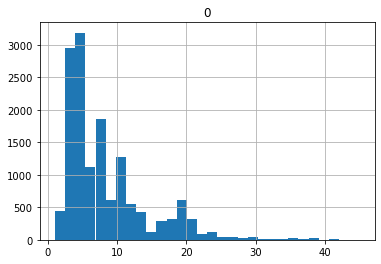

In [79]:
results = [p.waiting_time for 
               p in model.referrals if not p.waiting_time is None]

pd.DataFrame(results).hist(bins=30)

In [80]:
pd.DataFrame(results).describe()

,0
count,14541.000000
mean,8.193591
std,6.148316
min,1.000000
25%,4.000000
50%,6.000000
75%,11.000000
max,45.000000
